In [1]:
import os, cv2, sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from PIL import Image
from keras_preprocessing.image import array_to_img, img_to_array
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage import transform, data, img_as_float, exposure
from keras.models import *
from keras.optimizers import *

Using TensorFlow backend.


## Sample images that can be used for prediction

<Figure size 432x288 with 0 Axes>

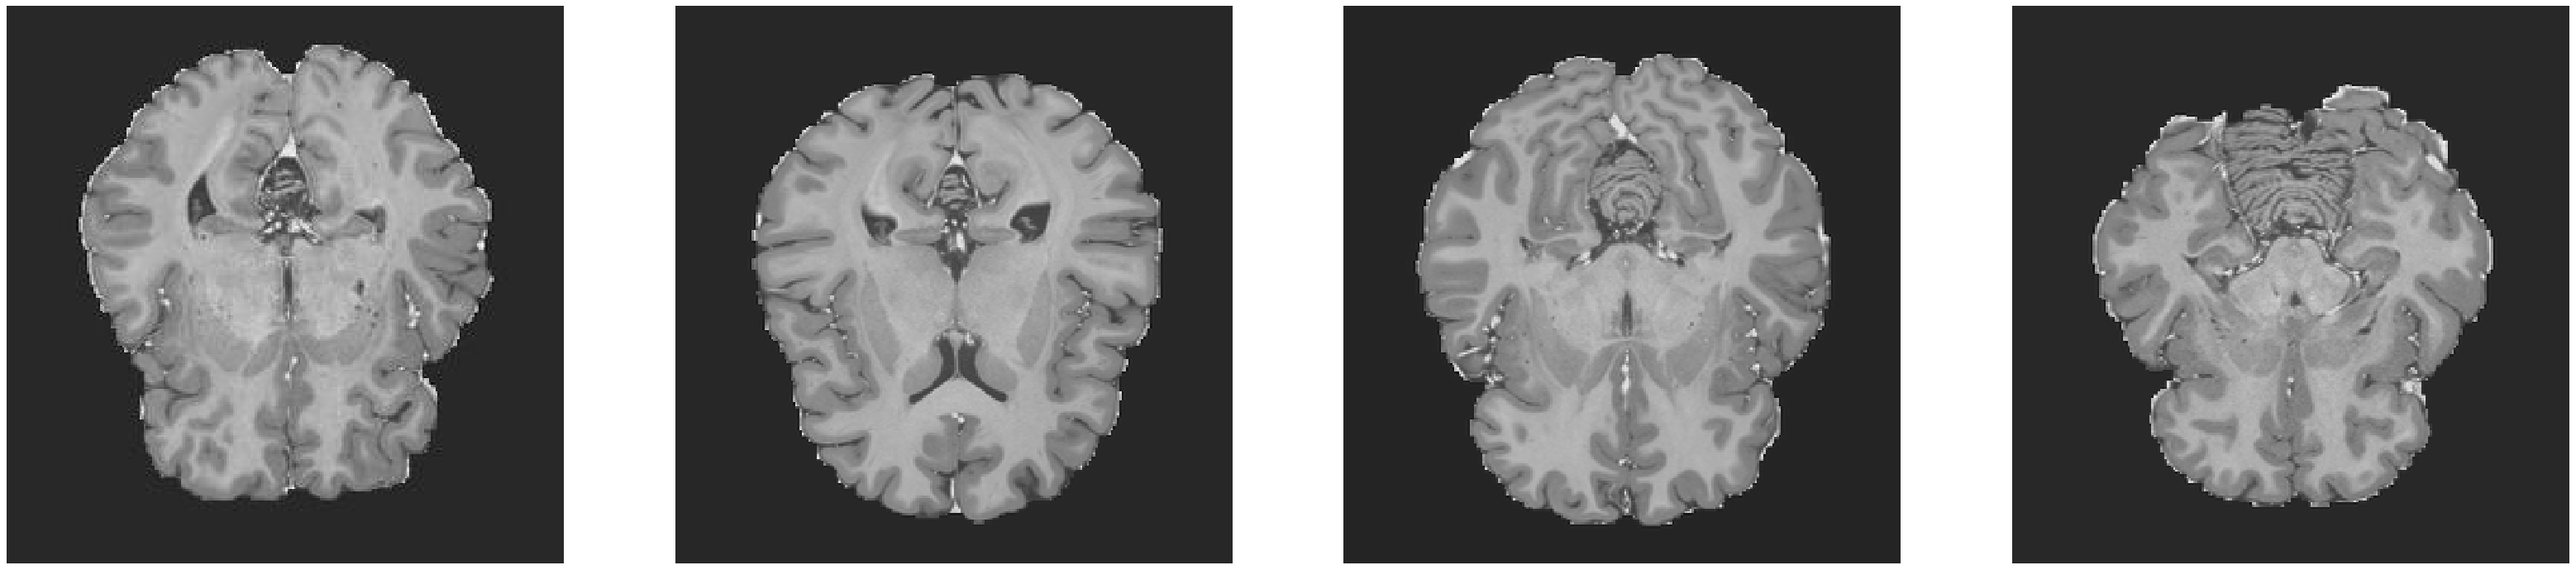

In [2]:
plt.figure()

# reading images
Image1 = cv2.imread('example_images/example_1.jpg')
Image2 = cv2.imread('example_images/example_2.png')
Image3 = cv2.imread('example_images/example_3.png')
Image4 = cv2.imread('example_images/example_4.png')


figure(figsize=(50, 40), dpi=80)

plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(Image1, cmap="gray")
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(Image2, cmap="gray")
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(Image3, cmap="gray")
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(Image4, cmap="gray")
plt.show()

# Define loss and metrics:

In [3]:
def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
           (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
        y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.2), 'float32') * K.cast(K.less(averaged_mask, 0.8), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
           weighted_dice_loss(y_true, y_pred, weight)
    return loss
	
def dice_acc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def jacard_acc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## Load the model and set path to test data

In [4]:
############################
# model path
model_path = "axial_model_82.hdf5"

# image to predict
sample = "example_images/example_4.png" 

# path to save model results
result_path = "results/"
#############################

## Methods for data pre-processing, model prediction, and data post-processing 

In [11]:
# load saved model and predict
def predict_CL(scan):

    model = load_model(model_path, custom_objects={'weighted_bce_dice_loss':                   
weighted_bce_dice_loss,'dice_acc':dice_acc,'jacard_acc':jacard_acc})
    
    # Print the model Summary
    model.summary()
    
    # Predict on input data
    predicted_CL = model.predict(scan, verbose=1)
     
    # Threshol value for the output model seg.
    predicted_CL[predicted_CL >= 0.5] = 1
    predicted_CL[predicted_CL < 0.5] = 0

    return predicted_CL

# Pad predicted image to be (256x256) original size.
def pad_with(c_x):
    n,r = c_x.shape
    c_y = np.zeros((n+160, r+128),dtype=c_x.dtype)
    c_y[100: 196, 62:190] = c_x
    return c_y


def load_data(file):
    # Load image:
    img = np.asarray(Image.open(file))

    # Create ndarray with shape (1,96,128):
    cropped_test = np.ndarray(shape=(1, 96, 128), dtype=np.float32)

    # Select the ROI from input image: 
    test_asmatrix =  np.asmatrix(img[:,:,0])
    lx, ly = test_asmatrix.shape
    cropped_test = test_asmatrix[100: 196, 62:190]

    # Normalize input data
    norm = (np.amax(cropped_test) - np.amin(cropped_test))
    if norm == 0:
        cropped_test = (cropped_test - np.amin(cropped_test))
    else:
        cropped_test = (cropped_test - np.amin(cropped_test)) / (np.amax(cropped_test) - np.amin(cropped_test))

    # Expand dim
    cropped_test = np.expand_dims(cropped_test, axis=0)
    cropped_test = np.expand_dims(cropped_test, axis=-1)

    return img, cropped_test

def postprocess(data):
    # Post-prosessing to remove some FP pixels.
    for y in range(pred_CL.shape[0]):
        pred_CL[y,: , 45:90,0][pred_CL[y,: , 45:90,0] > 0] = 0


    # Padding img to restore origanl size.
    new_im = pad_with(pred_CL[0,:,:,0])
    
    return new_im

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 96, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  320         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 128, 32)  64          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 128, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________

1/1 [==============================] - 1s 614ms/step


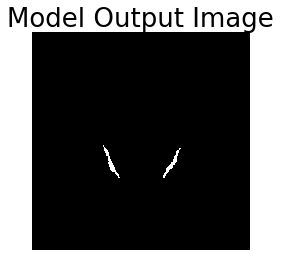

In [12]:
# Load and pre-process the input file
image, model_input = load_data(sample)

# Model predict
pred_CL = predict_CL(input_file)

# Apply post-processing
model_output = postprocess(pred_CL)

# Visualize and save model output
plt.imshow(model_output, cmap='gray')
plt.axis('off')
plt.title('Model Output Image', fontsize=26)
plt.savefig(os.path.join(result_path,'CL Result.jpg'), bbox_inches='tight', pad_inches=0)

<Figure size 432x288 with 0 Axes>

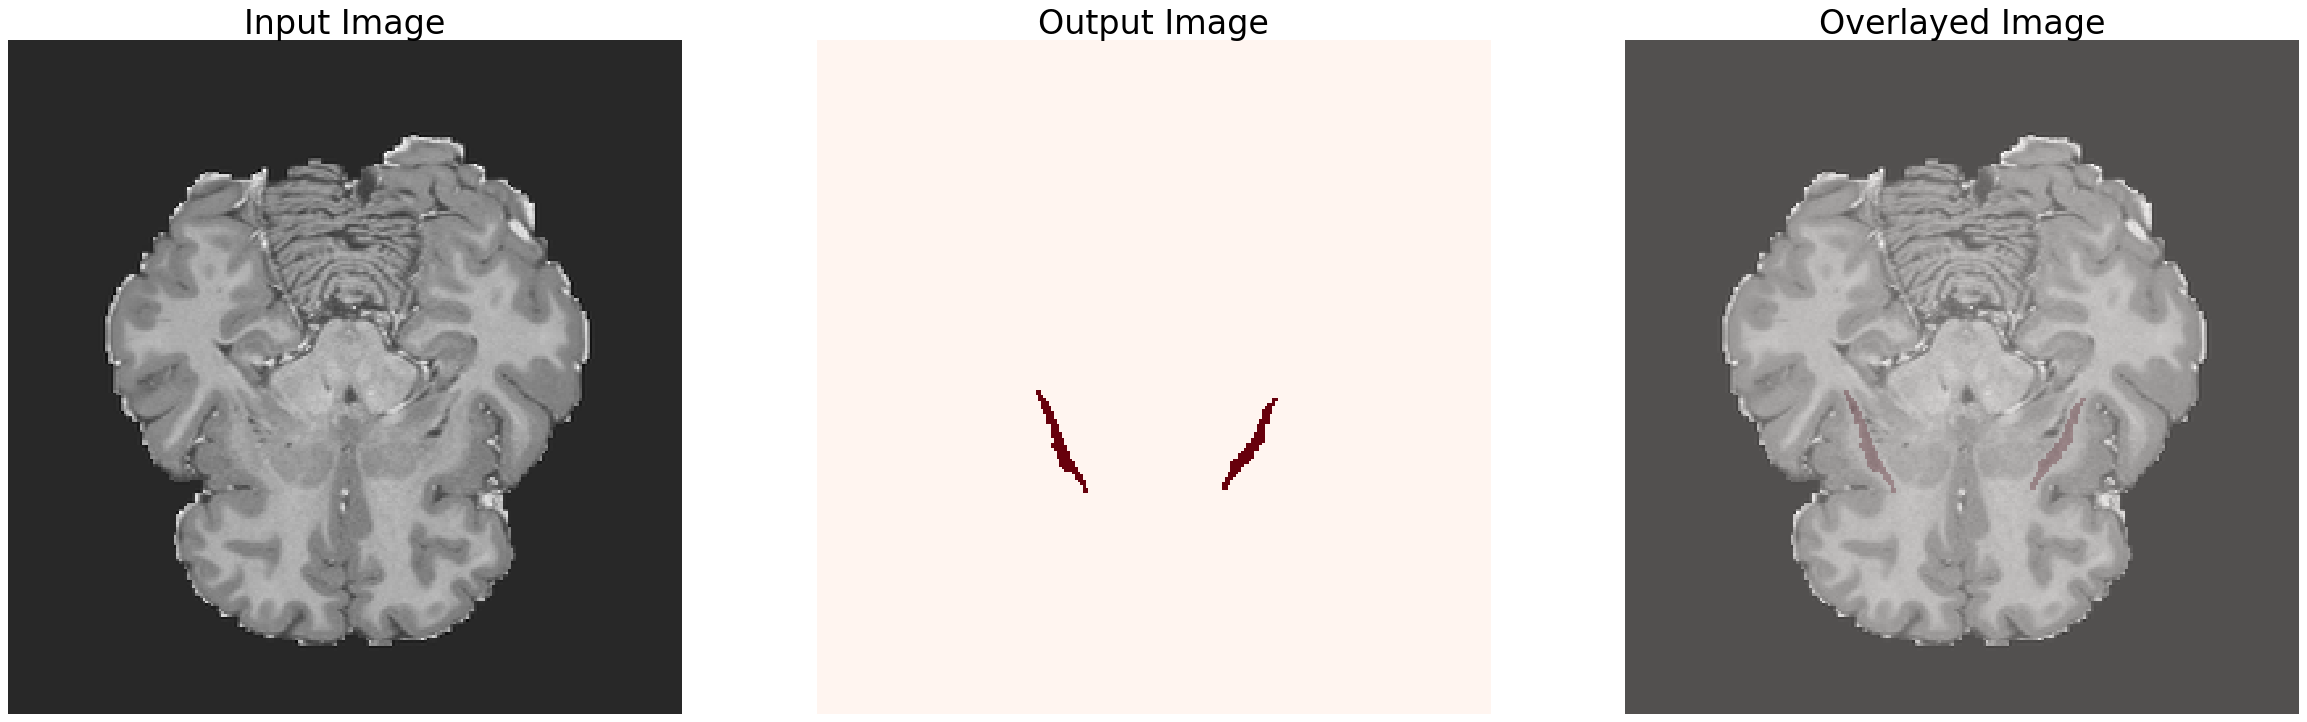

In [14]:
# Display the input image, model output, and overlayed image of input+output.
plt.figure()

figure(figsize=(50, 40), dpi=80)

plt.subplot(1, 4, 1)
plt.axis('off')
plt.title('Input Image', fontsize=30)
plt.imshow(image, cmap="gray")
plt.subplot(1, 4, 2)
plt.axis('off')
plt.title('Output Image', fontsize=30)
plt.imshow(model_output, cmap="Reds")
plt.subplot(1, 4, 3)
plt.axis('off')
plt.title('Overlayed Image', fontsize=30)
plt.imshow(image, cmap="gray")
plt.imshow(model_output, cmap="Reds", alpha=0.2)
plt.show()

# Result Image from AM-UNet paper

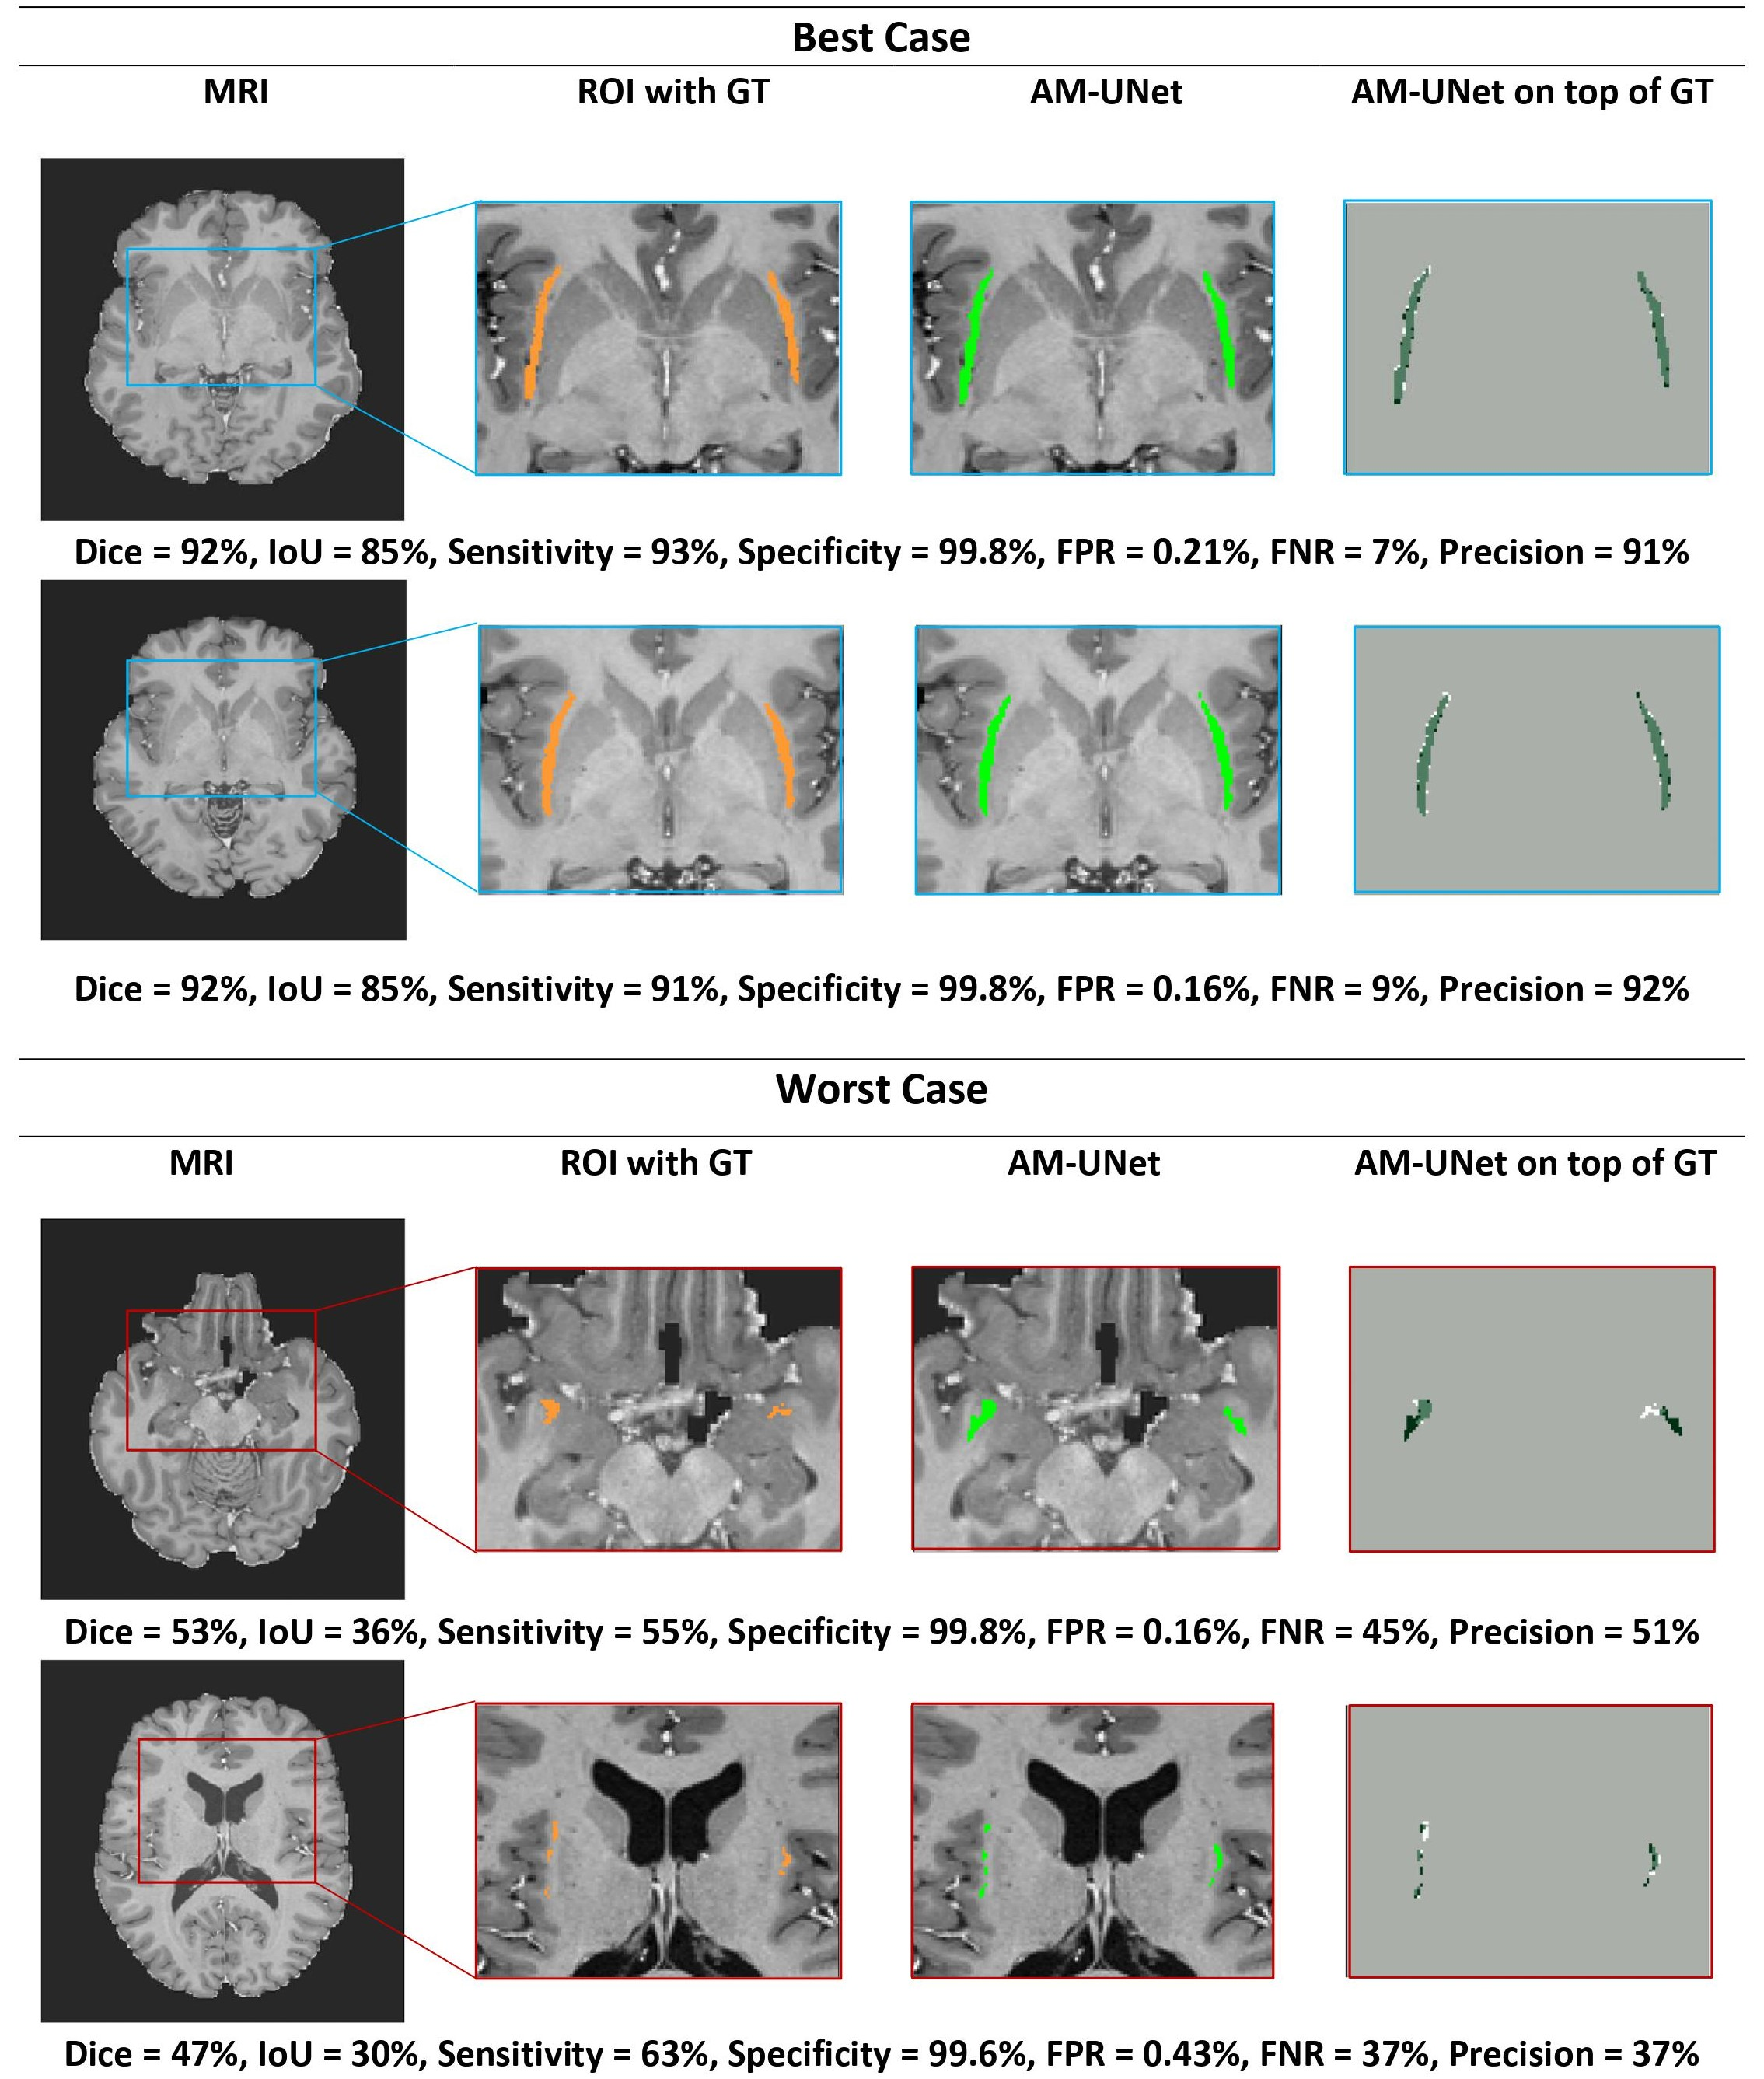